In [2]:
import pandas as pd
import os
import re
import numpy as np



In [3]:
aves = {}
te_groups = {}
matricess = []
for i in os.listdir(r'EEG_DATA\TE'):
    folder = rf'EEG_DATA\TE\{i}'
    folder_name = os.path.basename(folder.rstrip('/'))
    matrices = []

    for file in os.listdir(folder):
        if file.endswith('.txt'):
            path = os.path.join(folder, file)
            with open(path, 'r', encoding='utf-8') as f:
                text = f.read()
            tokens = re.findall(r'[-+]?\d*\.\d+e[-+]?\d+|[-+]?\d+\.\d+|[-+]?\d+', text)
            data = np.array([float(t) for t in tokens], dtype=float)
            if data.size == 127 * 127:
                matrix = data.reshape((127, 127))
                matrices.append(matrix)
            else:
                print(f"Skipping {file}: {data.size} numbers found (expected 16129)")

    average_matrix = np.mean(matrices, axis=0)
    aves[folder_name] = (average_matrix)
    te_groups[folder_name] = matrices
    matricess.append(matrices)

In [3]:
Genres = list(aves.keys())

In [4]:
TE_groups = np.abs(np.array(matricess))

In [4]:
# TE Null-Hypothesis Thresholding Pipeline
import numpy as np
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests

# -----------------------------
# Parameters
# -----------------------------
ALPHA = 0.05                  # significance level for surrogate test
N_SURROGATES = 1000          # number of surrogates for null distribution
N_SUBJECTS = 20              # per group
N_GROUPS = 12
N_NODES = 127
FDR_Q = 0.05

# -----------------------------
# Placeholder Functions
# -----------------------------
def generate_surrogates(te_value, n_surrogates=100):
    """
    Generate surrogate TE values from null distribution. 
    Placeholder uses Gaussian noise centered at zero.
    """
    np.random.seed(0)  # for reproducibility
    return np.random.normal(loc=0.0, scale=te_value/2, size=n_surrogates)

def compute_p_value(observed, surrogates):
    """
    Compute one-tailed p-value: proportion of surrogate values >= observed.
    """
    return (np.sum(surrogates >= observed) + 1) / (len(surrogates) + 1)

# -----------------------------
# Step 1: Generate Placeholder TE Data
# -----------------------------
TE_groups = np.abs(np.array(matricess))  # 12x20x127x127

# -----------------------------
# Step 2: Within-Subject Surrogate Testing
# -----------------------------
p_values_per_group = np.zeros((N_GROUPS, N_NODES, N_NODES))

for g in range(N_GROUPS):
    significance_counts = np.zeros((N_NODES, N_NODES))
    for s in range(N_SUBJECTS):
        te_matrix = TE_groups[g, s]
        for i in range(N_NODES):
            for j in range(N_NODES):
                if i == j:
                    continue
                observed_te = te_matrix[i, j]
                surrogates = generate_surrogates(observed_te, N_SURROGATES)
                p = compute_p_value(observed_te, surrogates)
                if p < ALPHA:
                    significance_counts[i, j] += 1
    # Step 3: Binomial test per edge
    for i in range(N_NODES):
        for j in range(N_NODES):
            if i == j:
                continue
            k = significance_counts[i, j]
            p_val  = binomtest(int(k), N_SUBJECTS, ALPHA, alternative='greater').pvalue
            p_values_per_group[g, i, j] = p_val

# -----------------------------
# Step 4: FDR Correction and Holding Matrices
# -----------------------------
holding_matrices = np.zeros((N_GROUPS, N_NODES, N_NODES), dtype=int)

for g in range(N_GROUPS):
    pvals = p_values_per_group[g].flatten()
    _, pvals_fdr, _, _ = multipletests(pvals, alpha=FDR_Q, method='fdr_bh')
    sig_mask = pvals_fdr < FDR_Q
    holding_matrices[g] = sig_mask.reshape((N_NODES, N_NODES)).astype(int)

# -----------------------------
# Step 5: Summary Output
# -----------------------------
for g in range(N_GROUPS):
    n_edges = np.sum(holding_matrices[g])
    print(f"Group {g+1}: {n_edges} significant edges after FDR correction")


Group 1: 16129 significant edges after FDR correction
Group 2: 16129 significant edges after FDR correction
Group 3: 16129 significant edges after FDR correction
Group 4: 16129 significant edges after FDR correction
Group 5: 16129 significant edges after FDR correction
Group 6: 16129 significant edges after FDR correction
Group 7: 16129 significant edges after FDR correction
Group 8: 16129 significant edges after FDR correction
Group 9: 16129 significant edges after FDR correction
Group 10: 16129 significant edges after FDR correction
Group 11: 16129 significant edges after FDR correction
Group 12: 16129 significant edges after FDR correction


In [3]:
# # TE Null-Hypothesis Thresholding Pipeline with Autoencoder Sparsification
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.preprocessing import MinMaxScaler

# # -----------------------------
# # Parameters
# # -----------------------------
# N_GROUPS = 12
# N_SUBJECTS = 20
# N_NODES = 127
# LATENT_DIM = 100
# N_EPOCHS = 100
# LR = 1e-3
# SPARSITY_THRESHOLD = 0.05  # epsilon for binary filter


# # -----------------------------
# # Autoencoder Definition
# # -----------------------------
# class TEAutoencoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(TEAutoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.ReLU(),
#             nn.Linear(512, latent_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 512),
#             nn.ReLU(),
#             nn.Linear(512, input_dim),
#             nn.Sigmoid()  # Normalize output to [0,1]
#         )

#     def forward(self, x):
#         latent = self.encoder(x)
#         reconstructed = self.decoder(latent)
#         return reconstructed

# # -----------------------------
# # Step 1: Train Autoencoder Per Group
# # -----------------------------
# binary_masks = []

# for g in range(N_GROUPS):
#     print(f"Training autoencoder for group {g+1}...")
#     group_data = TE_groups[g]  # shape (20, 127, 127)

#     # Preprocess: flatten each matrix and scale to [0,1]
#     flattened = group_data.reshape(N_SUBJECTS, -1)
#     scaler = MinMaxScaler()
#     scaled = scaler.fit_transform(flattened)

#     # Convert to torch tensors
#     X = torch.tensor(scaled, dtype=torch.float32)
#     model = TEAutoencoder(input_dim=X.shape[1], latent_dim=LATENT_DIM)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=LR)

#     # Training loop
#     model.train()
#     for epoch in range(N_EPOCHS):
#         optimizer.zero_grad()
#         output = model(X)
#         loss = criterion(output, X)
#         loss.backward()
#         optimizer.step()
#         if (epoch + 1) % 20 == 0:
#             print(f"Epoch {epoch+1}/{N_EPOCHS}, Loss: {loss.item():.6f}")

#     # Reconstruct and average outputs
#     model.eval()
#     with torch.no_grad():
#         recon = model(X).numpy()
#     recon_avg = np.mean(recon, axis=0)
#     recon_matrix = recon_avg.reshape(N_NODES, N_NODES)

#     # Create binary mask
#     binary_mask = (recon_matrix > SPARSITY_THRESHOLD).astype(int)
#     binary_masks.append(binary_mask)

# # -----------------------------
# # Final Output
# # -----------------------------
# for g, mask in enumerate(binary_masks):
#     print(f"Group {g+1}: {np.sum(mask)} edges retained in binary mask")


In [2]:
# # TE Null-Hypothesis Thresholding Pipeline with SAE and Strict Sparsity
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import networkx as nx
# from sklearn.preprocessing import MinMaxScaler

# # -----------------------------
# # Parameters
# # -----------------------------
# N_GROUPS = 12
# N_SUBJECTS = 20
# N_NODES = 127
# LATENT_DIM = 50
# N_EPOCHS = 300
# LR = 1e-3
# SPARSITY_PENALTY = 1e-1
# TARGET_SPARSITY = 0.005  # 0.5% activation
# EDGE_LIMIT = 500

# # -----------------------------
# # Simulated TE Data

# # -----------------------------
# # Sparse Autoencoder Definition
# # -----------------------------
# class SparseAutoencoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(SparseAutoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, latent_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, input_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         z = self.encoder(x)
#         x_hat = self.decoder(z)
#         return x_hat, z

# # -----------------------------
# # Train SAE Per Group and Extract Binary Masks with ≤500 Edges
# # -----------------------------
# binary_masks = []

# def kl_divergence(p, p_hat):
#     return p * torch.log(p / (p_hat + 1e-10)) + (1 - p) * torch.log((1 - p) / (1 - p_hat + 1e-10))

# for g in range(N_GROUPS):
#     print(f"Training sparse autoencoder for group {g+1}...")
#     group_data = TE_groups[g]
#     flattened = group_data.reshape(N_SUBJECTS, -1)
#     scaler = MinMaxScaler()
#     scaled = scaler.fit_transform(flattened)
#     X = torch.tensor(scaled, dtype=torch.float32)

#     model = SparseAutoencoder(input_dim=X.shape[1], latent_dim=LATENT_DIM)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=LR)

#     for epoch in range(N_EPOCHS):
#         model.train()
#         optimizer.zero_grad()
#         x_hat, z = model(X)
#         p_hat = torch.clamp(torch.mean(z, dim=0), 1e-6, 1 - 1e-6)
#         sparsity_loss = torch.mean(kl_divergence(torch.tensor(TARGET_SPARSITY), p_hat))
#         loss = criterion(x_hat, X) + SPARSITY_PENALTY * sparsity_loss
#         if torch.isnan(loss):
#             print("NaN in loss detected, breaking training.")
#             break
#         loss.backward()
#         optimizer.step()
#         if (epoch + 1) % 50 == 0:
#             print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}, Sparsity: {torch.mean(p_hat).item():.4f}")

#     # Reconstruct and average
#     model.eval()
#     with torch.no_grad():
#         recon, _ = model(X)
#     recon_avg = torch.mean(recon, dim=0).numpy().reshape(N_NODES, N_NODES)

#     # Create binary mask with ≤500 edges and full component
#     threshold = 0.9
#     while True:
#         bin_mask = (recon_avg > threshold).astype(int)
#         G = nx.from_numpy_array(bin_mask, create_using=nx.DiGraph)
#         components = list(nx.weakly_connected_components(G))
#         largest_component_size = len(max(components, key=len)) if components else 0
#         edge_count = np.sum(bin_mask)
#         if largest_component_size >= N_NODES and edge_count <= EDGE_LIMIT:
#             break
#         threshold *= 0.95
#         if threshold < 1e-4:
#             print(f"Group {g+1}: could not satisfy edge limit and connectivity together.")
#             break

#     binary_masks.append(bin_mask)
#     print(f"Group {g+1}: {edge_count} edges, final threshold: {threshold:.4f}")

### Loop Distribution

In [1]:
# # TE Network Sparsification with SAE + Edge Attention
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.preprocessing import MinMaxScaler

# # -----------------------------
# # Parameters
# # -----------------------------
# N_GROUPS = 12
# N_SUBJECTS = 20
# N_NODES = 127
# LATENT_DIM = 50
# N_EPOCHS = 200
# LR = 1e-3
# EDGE_LIMIT = 616

# # -----------------------------
# # Simulated TE Data (replace with real TE matrices)

# # -----------------------------
# # Sparse Autoencoder Definition
# # -----------------------------
# class SparseAutoencoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(SparseAutoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, latent_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, input_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         z = self.encoder(x)
#         x_hat = self.decoder(z)
#         return x_hat

# # -----------------------------
# # Edge Attention Network Definition
# # -----------------------------
# class EdgeAttention(nn.Module):
#     def __init__(self, input_dim):
#         super(EdgeAttention, self).__init__()
#         self.attn = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.attn(x).squeeze(-1)

# # -----------------------------
# # Process Each Group
# # -----------------------------
# binary_masks = []

# for g in range(N_GROUPS):
#     print(f"Processing group {g+1}...")
#     group_data = TE_groups[g]
#     flattened = group_data.reshape(N_SUBJECTS, -1)
#     scaler = MinMaxScaler()
#     scaled = scaler.fit_transform(flattened)
#     X = torch.tensor(scaled, dtype=torch.float32)

#     # --- Train Sparse Autoencoder ---
#     model = SparseAutoencoder(input_dim=X.shape[1], latent_dim=LATENT_DIM)
#     optimizer = optim.Adam(model.parameters(), lr=LR)
#     criterion = nn.MSELoss()
#     for epoch in range(N_EPOCHS):
#         model.train()
#         optimizer.zero_grad()
#         x_hat = model(X)
#         loss = criterion(x_hat, X)
#         loss.backward()
#         optimizer.step()
#         #if (epoch + 1) % 50 == 0:
#             #print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

#     # --- Prepare Edge Features for Attention Network ---
#     model.eval()
#     with torch.no_grad():
#         recon = model(X).numpy().reshape(N_SUBJECTS, N_NODES, N_NODES)

#     # Edge-wise mean and variance across subjects
#     edge_features = []
#     for i in range(N_NODES):
#         for j in range(N_NODES):
#             if i == j:
#                 edge_features.append([0, 0])
#             else:
#                 edge_vals = recon[:, i, j]
#                 edge_features.append([np.mean(edge_vals), np.std(edge_vals)])

#     edge_features = torch.tensor(edge_features, dtype=torch.float32)

#     # --- Train Edge Attention Network ---
#     attn_model = EdgeAttention(input_dim=2)
#     attn_optimizer = optim.Adam(attn_model.parameters(), lr=LR)

#     for epoch in range(100):
#         attn_model.train()
#         attn_optimizer.zero_grad()
#         attn_scores = attn_model(edge_features)
#         loss = torch.mean((attn_scores - 0.5) ** 2)  # center around 0.5
#         loss.backward()
#         attn_optimizer.step()

#     attn_model.eval()
#     with torch.no_grad():
#         attn_scores = attn_model(edge_features).numpy()

#     # --- Create Sparse Binary Mask ---
#     top_indices = np.argsort(attn_scores)[-EDGE_LIMIT:]
#     mask = np.zeros((N_NODES, N_NODES), dtype=int)
#     for idx in top_indices:
#         i, j = divmod(idx, N_NODES)
#         mask[i, j] = 1

#     # # Ensure connectivity
#     # G = nx.from_numpy_array(mask, create_using=nx.DiGraph)
#     # components = list(nx.weakly_connected_components(G))
#     # largest_size = len(max(components, key=len)) if components else 0

#     # if largest_size < N_NODES:
#     #     print(f"Group {g+1}: reconnecting isolated nodes...")
#     #     needed = set(range(N_NODES)) - set.union(*components)
#     #     for node in needed:
#     #         mask[node, np.random.choice(N_NODES)] = 1

#     binary_masks.append(mask)
#     print(f"Group {g+1}: {np.sum(mask)} edges retained after attention filtering.")

In [7]:
# TE Network Sparsification with SAE + Entropy-Based Edge Attention
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# -----------------------------
# Parameters
# -----------------------------
N_GROUPS = 12
N_SUBJECTS = 20
N_NODES = 127
LATENT_DIM = 50
N_EPOCHS = 200
LR = 1e-3
ENTROPY_PERCENTILE = 15  # Keep edges with lowest entropy (most stable)

# -----------------------------
# Simulated TE Data (replace with real TE matrices)
#TE_groups = np.abs(np.random.rand(N_GROUPS, N_SUBJECTS, N_NODES, N_NODES))

# -----------------------------
# Sparse Autoencoder Definition
# -----------------------------
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# -----------------------------
# Process Each Group
# -----------------------------
binary_masks = []

for g in range(N_GROUPS):
    print(f"Processing group {g+1} with entropy-based edge filtering...")
    group_data = TE_groups[g]
    flattened = group_data.reshape(N_SUBJECTS, -1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(flattened)
    X = torch.tensor(scaled, dtype=torch.float32)

    # --- Train Sparse Autoencoder ---
    model = SparseAutoencoder(input_dim=X.shape[1], latent_dim=LATENT_DIM)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    for epoch in range(N_EPOCHS):
        model.train()
        optimizer.zero_grad()
        x_hat = model(X)
        loss = criterion(x_hat, X)
        loss.backward()
        optimizer.step()
        # if (epoch + 1) % 50 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

    # --- Reconstruct and Compute Entropy ---
    model.eval()
    with torch.no_grad():
        recon = model(X).numpy().reshape(N_SUBJECTS, N_NODES, N_NODES)

    entropy_scores = []
    for i in range(N_NODES):
        for j in range(N_NODES):
            if i == j:
                entropy_scores.append(100.0)  # artificially high to skip diagonals
            else:
                values = recon[:, i, j]
                hist, _ = np.histogram(values, bins=10, range=(0, 1), density=True)
                ent = entropy(hist + 1e-10)  # avoid log(0)
                entropy_scores.append(ent)

    entropy_scores = np.array(entropy_scores)
    threshold = np.percentile(entropy_scores, ENTROPY_PERCENTILE)
    selected = entropy_scores <= threshold

    mask = np.zeros((N_NODES, N_NODES), dtype=int)
    for idx, keep in enumerate(selected):
        if keep:
            i, j = divmod(idx, N_NODES)
            mask[i, j] = 1

    # Ensure connectivity
    # G = nx.from_numpy_array(mask, create_using=nx.DiGraph)
    # components = list(nx.weakly_connected_components(G))
    # largest_size = len(max(components, key=len)) if components else 0

    # if largest_size < N_NODES:
    #     print(f"Group {g+1}: reconnecting isolated nodes...")
    #     isolated = set(range(N_NODES)) - set.union(*components)
    #     for node in isolated:
    #         target = np.random.choice(list(set(range(N_NODES)) - {node}))
    #         mask[node, target] = 1

    binary_masks.append(mask)
    print(f"Group {g+1}: {np.sum(mask)} edges retained with entropy filter.")

Processing group 1 with entropy-based edge filtering...
Group 1: 2495 edges retained with entropy filter.
Processing group 2 with entropy-based edge filtering...
Group 2: 2665 edges retained with entropy filter.
Processing group 3 with entropy-based edge filtering...
Group 3: 2525 edges retained with entropy filter.
Processing group 4 with entropy-based edge filtering...
Group 4: 2440 edges retained with entropy filter.
Processing group 5 with entropy-based edge filtering...
Group 5: 2580 edges retained with entropy filter.
Processing group 6 with entropy-based edge filtering...
Group 6: 2645 edges retained with entropy filter.
Processing group 7 with entropy-based edge filtering...
Group 7: 3190 edges retained with entropy filter.
Processing group 8 with entropy-based edge filtering...
Group 8: 2420 edges retained with entropy filter.
Processing group 9 with entropy-based edge filtering...
Group 9: 2733 edges retained with entropy filter.
Processing group 10 with entropy-based edge fi

### Eigenvectors

In [11]:
A = matricess[1][0]

In [12]:
eigvals, eigvecs = np.linalg.eig(A)

In [18]:
sorted_vals = np.sort(eigvals.real)[::-1]
differences = sorted_vals[:-1] - sorted_vals[1:]

In [13]:
diff = {}
eig  = {}
for gen in range(12):
    diff_list = []
    Eval = []
    for mat in range(20):
        A = matricess[gen][mat]
        eigvals, eigvecs = np.linalg.eig(A)
        sorted_vals = np.sort(eigvals.real)[::-1]
        differences = sorted_vals[:-1] - sorted_vals[1:]
        diff_list.append(differences)
        Eval.append(eigvals.real)


    arrays_stacked = np.vstack(diff_list)      
    averages = np.mean(arrays_stacked, axis=0)
    diff[Genres[gen]] = averages
    arrays_stacked2 = np.vstack(Eval)     
    averages2 = np.mean(arrays_stacked2, axis=0)
    eig[Genres[gen]] = averages2

array([ 9.40623187e-02+0.j        , -2.19094054e-03-0.03015324j,
       -2.19094054e-03+0.03015324j,  1.04974727e-02-0.00614909j,
        1.04974727e-02+0.00614909j, -1.18907565e-01+0.j        ,
        2.55181154e-03+0.j        , -4.04913652e-03-0.01151193j,
       -4.04913652e-03+0.01151193j,  2.13147050e-02-0.01068109j,
        2.13147050e-02+0.01068109j,  6.29500075e-02+0.00646941j,
        6.29500075e-02-0.00646941j,  1.69975471e-02+0.00728757j,
        1.69975471e-02-0.00728757j,  4.60793618e-04+0.01776537j,
        4.60793618e-04-0.01776537j,  4.30889888e-02+0.j        ,
       -1.49603940e-04+0.j        ,  1.65937847e-01+0.j        ,
       -3.65227970e-02+0.j        , -6.86989430e-03+0.j        ,
       -4.36726568e-02+0.j        ,  1.67625108e-02+0.j        ,
        3.08107489e-02+0.02594106j,  3.08107489e-02-0.02594106j,
       -8.72402480e-03-0.00359297j, -8.72402480e-03+0.00359297j,
       -2.42511540e-02+0.j        , -2.37267230e-02+0.j        ,
        1.44070575e-02+0.

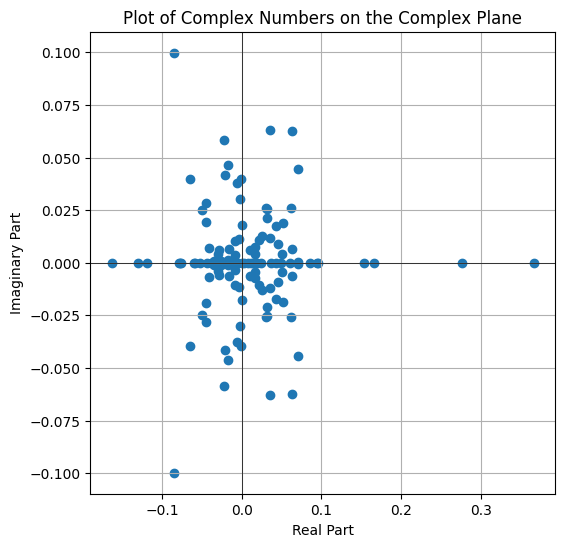

In [23]:
real_parts = [z.real for z in eigvecs[1]]
imag_parts = [z.imag for z in eigvecs[1]]

# Create the plot
plt.figure(figsize=(6, 6))
plt.scatter(real_parts, imag_parts)

# Add labels and grid
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Plot of Complex Numbers on the Complex Plane")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.grid(True)

plt.show()

In [18]:
eig[Genres[1]]

array([ 6.19916357e+01,  5.59094416e+00,  5.13862253e+00,  1.48041637e+00,
        9.51320092e-01,  3.38238722e-01, -1.12695895e-01, -1.76459374e-01,
       -4.72232503e-01, -4.02921667e-02, -4.10340505e-01, -7.09298260e-01,
       -5.15211497e-01, -7.41206900e-01, -6.77738953e-01, -7.99766112e-01,
       -6.47184628e-01, -7.37861248e-01, -9.16018823e-01, -8.69300315e-01,
       -4.86746659e-01, -6.65315227e-01, -6.61265360e-01, -5.76201747e-01,
       -6.38304931e-01, -5.64469524e-01, -4.89375437e-01, -6.12679724e-01,
       -6.64030437e-01, -7.37193849e-01, -6.86163053e-01, -4.18754582e-01,
       -7.00454308e-01, -6.17124142e-01, -4.10183056e-01, -4.61389509e-01,
       -5.86292696e-01, -5.23220582e-01, -6.80837508e-01, -6.99400088e-01,
       -6.31111380e-01, -6.05495702e-01, -6.65925420e-01, -6.72851431e-01,
       -5.88432756e-01, -5.57177310e-01, -5.39482414e-01, -5.55012150e-01,
       -6.20196000e-01, -6.25753887e-01, -6.66357539e-01, -5.47979987e-01,
       -5.87312644e-01, -

c:\Users\Abolfazl HaqiqiFar\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Abolfazl HaqiqiFar\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


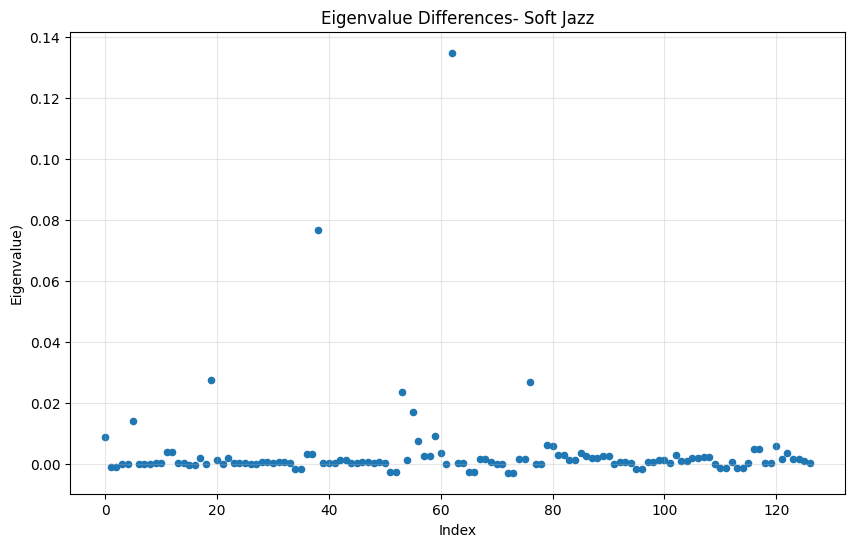

In [25]:
vec = eigvecs[1] * eigvecs[1] 
plt.figure(figsize=(10, 6))
plt.scatter(range(127), vec, s=20)   # s = marker size
plt.title(f"Eigenvalue Differences- {Genres[i]}")
plt.xlabel("Index")
plt.ylabel("Eigenvalue)")
plt.grid(True, alpha=0.3)

plt.show()

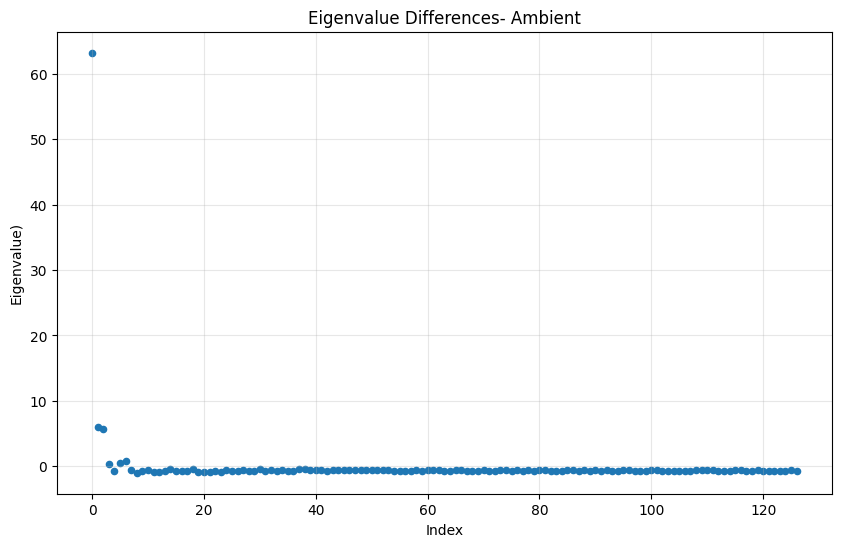

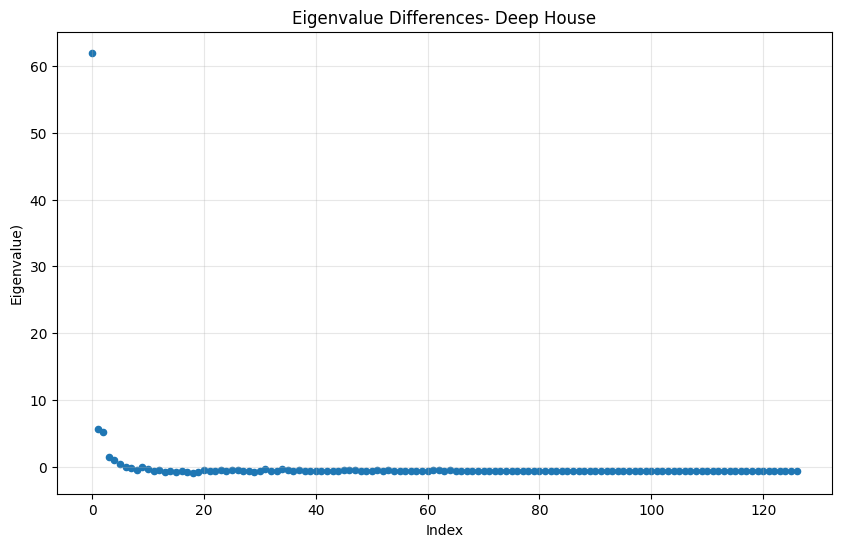

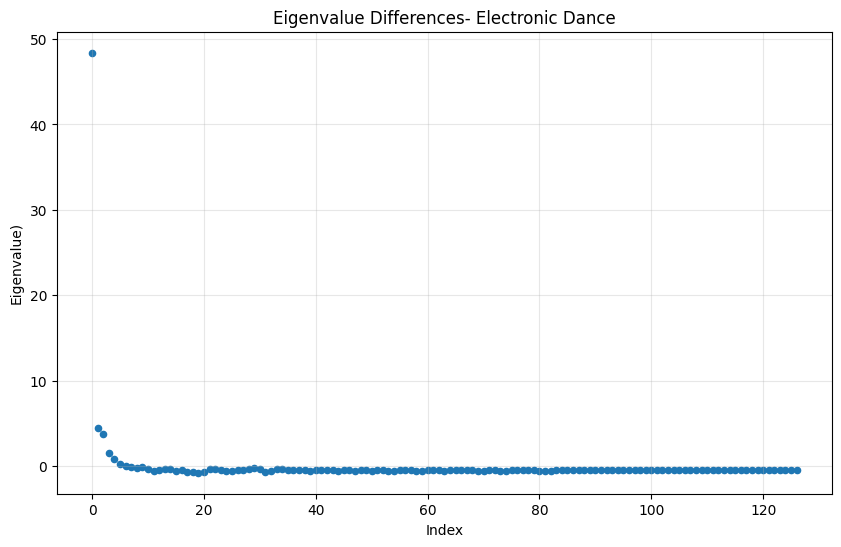

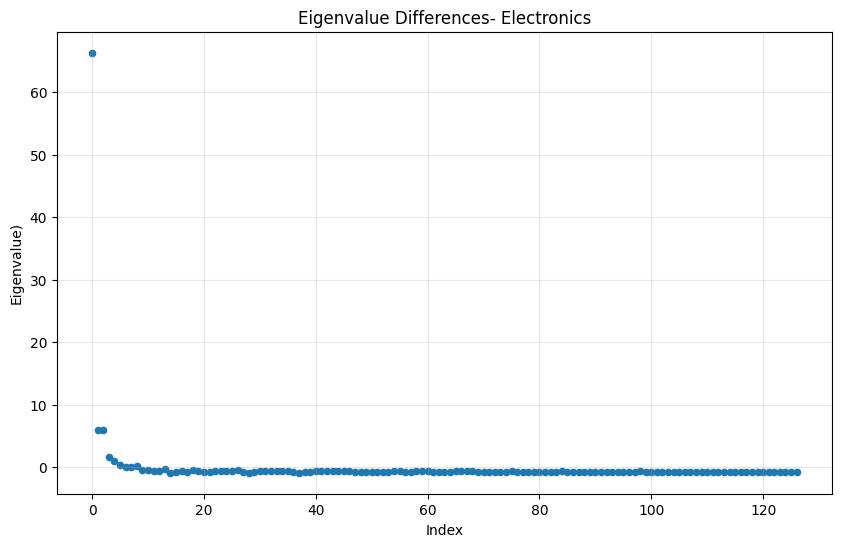

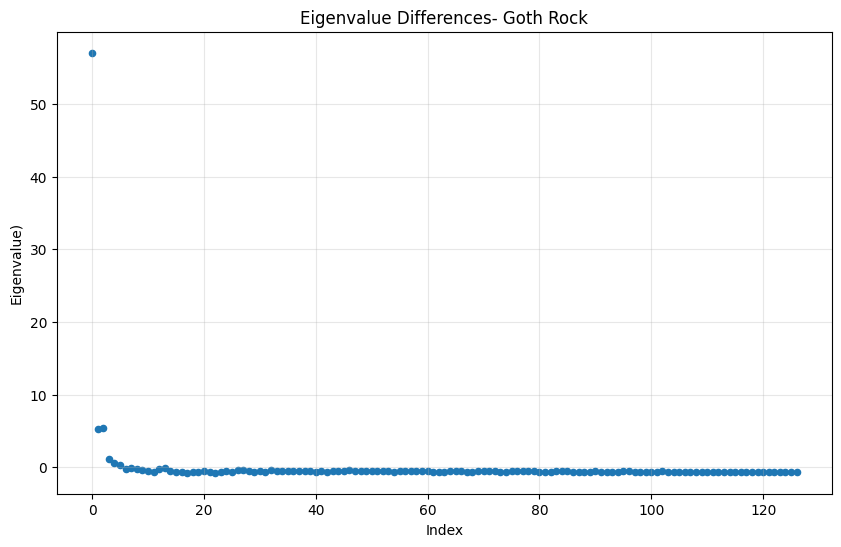

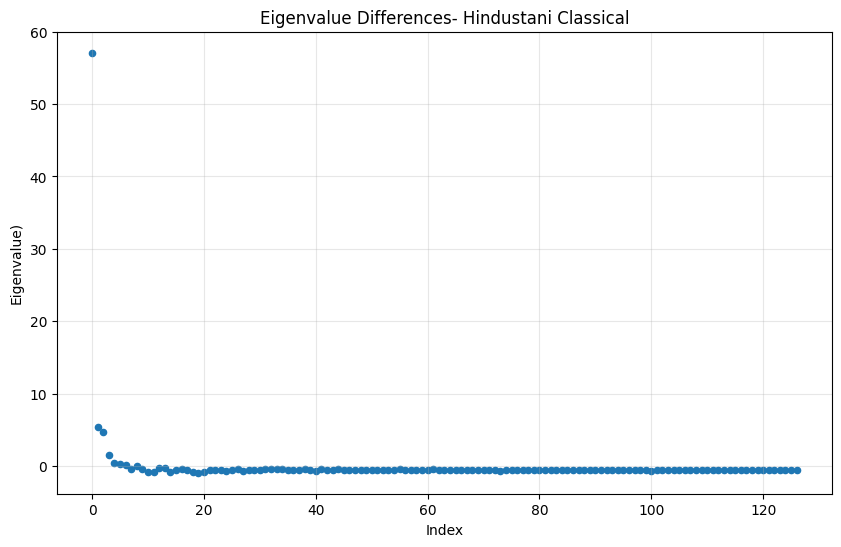

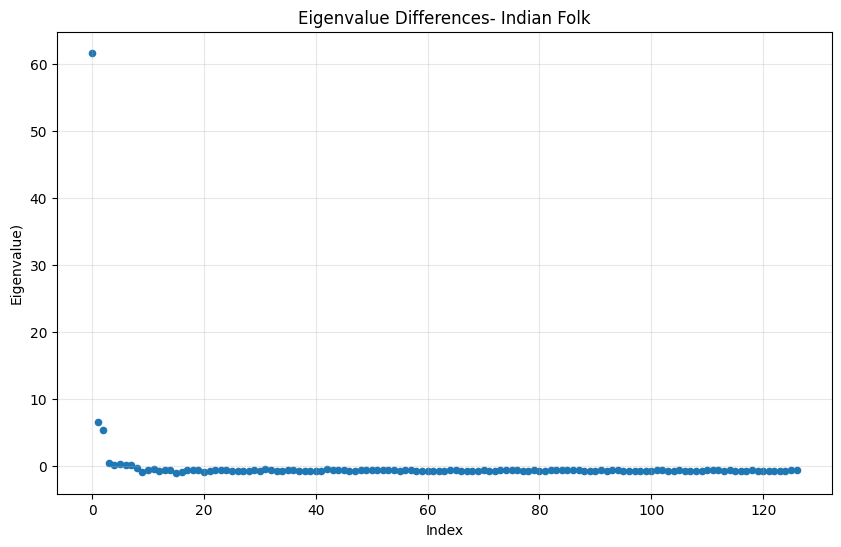

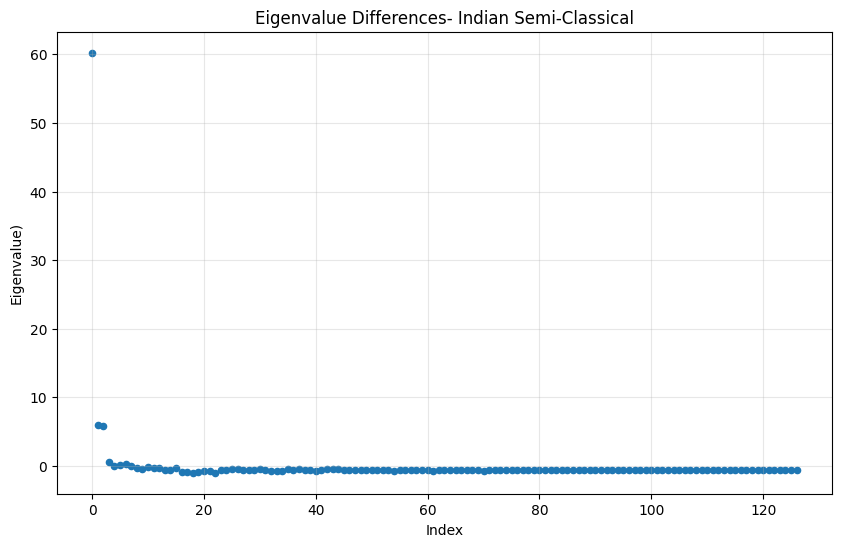

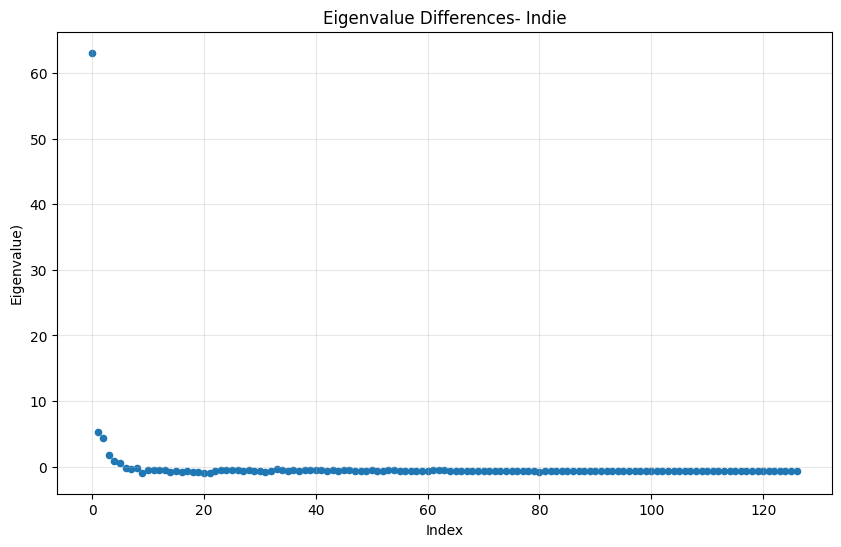

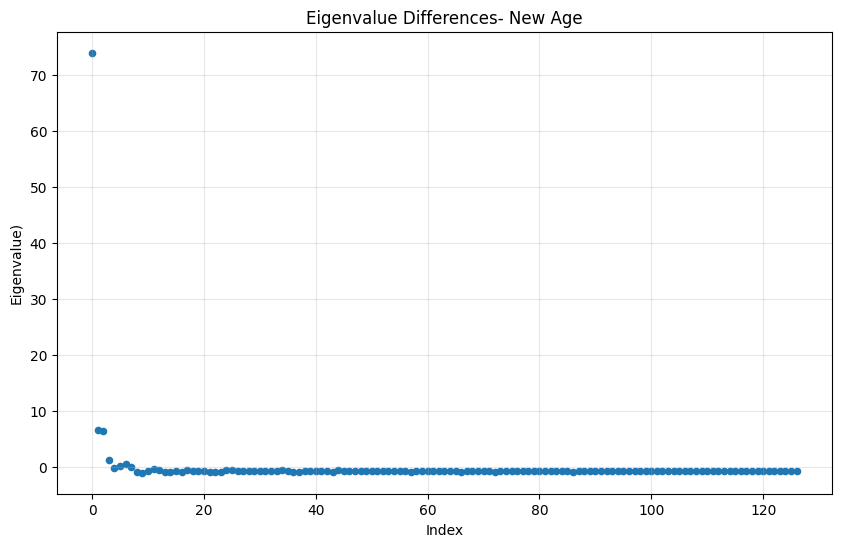

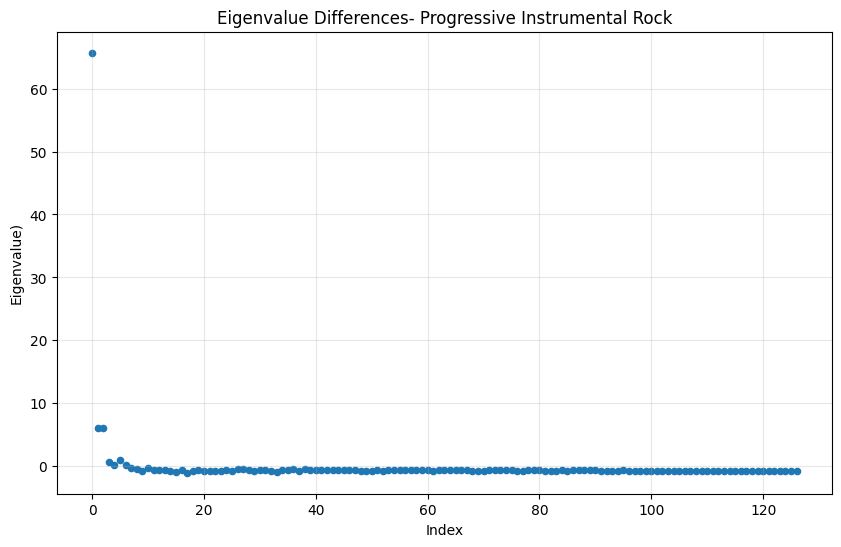

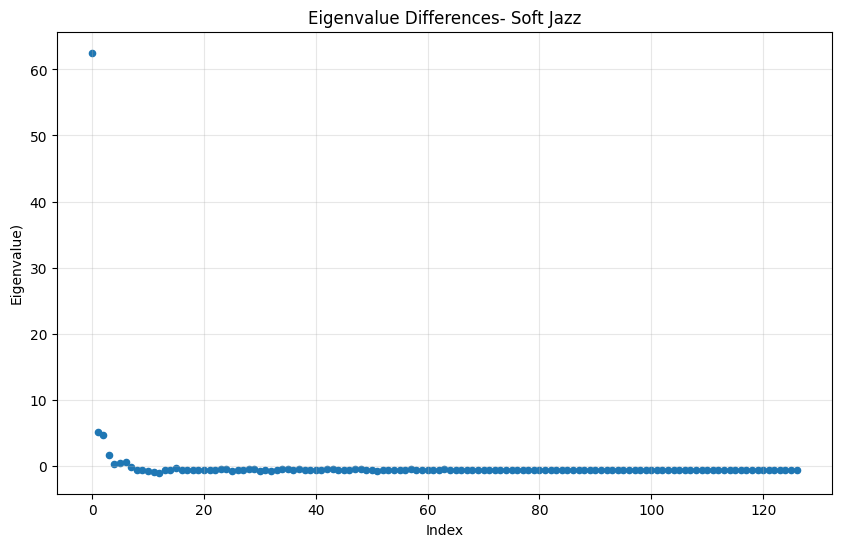

In [17]:
import matplotlib.pyplot as plt
x = np.arange(127)

for i in range(12):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, eig[Genres[i]], s=20)   # s = marker size
    plt.title(f"Eigenvalue Differences- {Genres[i]}")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue)")
    plt.grid(True, alpha=0.3)

    plt.show()

In [60]:
diff_rand = {}

for gen in range(12):
    randoms = []
    for mat in range(20):       
        A = matricess[gen][mat]
        for i in range(10):
                random_matrix = A.copy().flatten()
                np.random.shuffle(random_matrix)
                random_matrix = random_matrix.reshape(A.shape)
                eigvals, eigvecs = np.linalg.eig(random_matrix)
                sorted_vals = np.sort(eigvals.real)[::-1]
                differences = sorted_vals[:-1] - sorted_vals[1:]
                randoms.append(differences)

        # arrays_stacked = np.vstack(randoms)      
        # averages = np.mean(arrays_stacked, axis=0)
        # diff_list.append(averages)
    diff_rand[Genres[gen]] = randoms

In [66]:
diff_rand = {}

for gen in range(12):
    randoms = []
    for mat in range(20):       
        A = matricess[gen][mat]
        mu = np.mean(A)
        sigma = np.std(A)
        for i in range(10):
                random_matrix = np.random.normal(mu, sigma, size=A.shape)
                eigvals, eigvecs = np.linalg.eig(random_matrix)
                sorted_vals = np.sort(eigvals.real)[::-1]
                differences = sorted_vals[:-1] - sorted_vals[1:]
                randoms.append(differences)
        # arrays_stacked = np.vstack(randoms)      
        # averages = np.mean(arrays_stacked, axis=0)
        # diff_list.append(averages)
    diff_rand[Genres[gen]] = randoms

In [57]:
Genres[gen]

'Soft Jazz'

In [61]:
diff_rand['Soft Jazz']

[array([3.85978570e+01, 0.00000000e+00, 6.36753433e-02, 0.00000000e+00,
        1.64003159e-01, 1.40348823e-01, 4.87851582e-02, 0.00000000e+00,
        4.77639939e-02, 0.00000000e+00, 1.73956008e-01, 0.00000000e+00,
        2.21068812e-02, 1.25627167e-01, 0.00000000e+00, 1.69384528e-02,
        0.00000000e+00, 9.92163990e-03, 0.00000000e+00, 6.21400123e-02,
        0.00000000e+00, 7.09232141e-03, 0.00000000e+00, 6.03728892e-02,
        0.00000000e+00, 1.36284531e-01, 0.00000000e+00, 3.58962824e-02,
        0.00000000e+00, 1.42561049e-01, 0.00000000e+00, 3.13232348e-02,
        2.74354808e-02, 0.00000000e+00, 1.08199899e-01, 0.00000000e+00,
        1.70470338e-01, 0.00000000e+00, 1.08356082e-01, 0.00000000e+00,
        2.13424474e-02, 0.00000000e+00, 9.15238226e-02, 0.00000000e+00,
        9.60582947e-03, 2.87268862e-02, 0.00000000e+00, 3.31777181e-02,
        0.00000000e+00, 5.52462568e-02, 0.00000000e+00, 1.51221327e-02,
        0.00000000e+00, 1.22847915e-01, 0.00000000e+00, 1.685140

In [64]:
Genres[11]

'Soft Jazz'

C:\Users\Abolfazl HaqiqiFar\AppData\Local\Temp\ipykernel_3284\1818071545.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


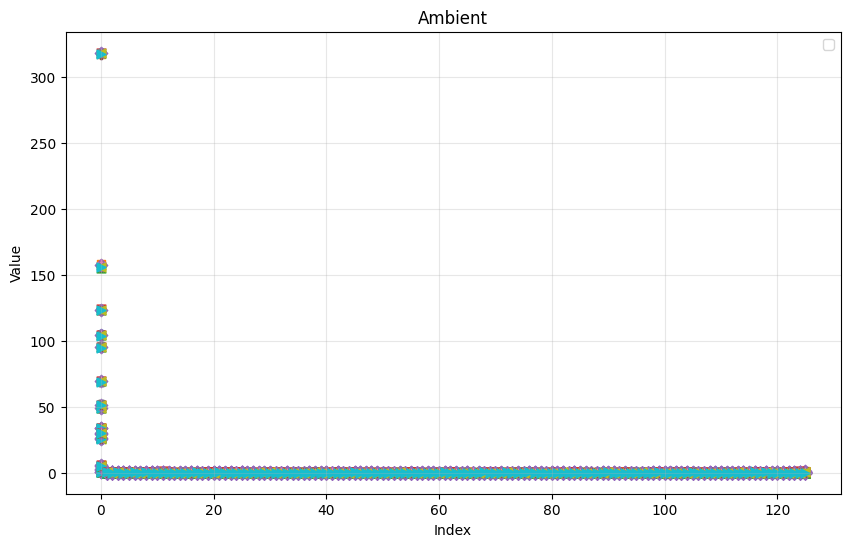

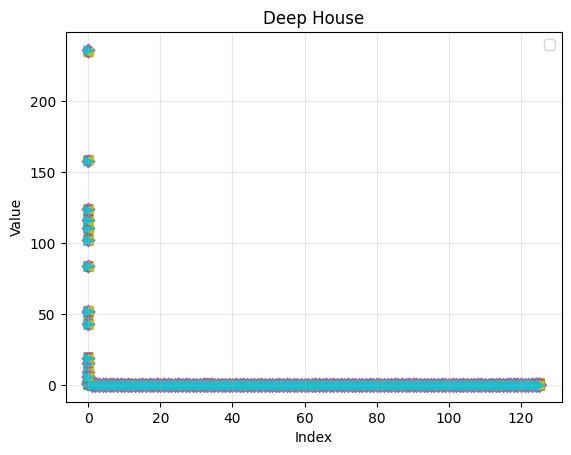

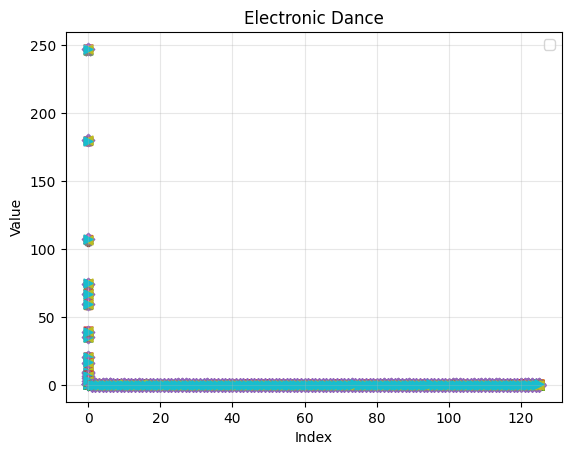

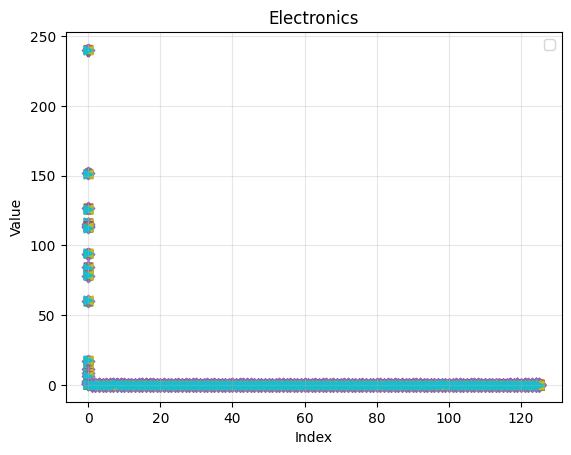

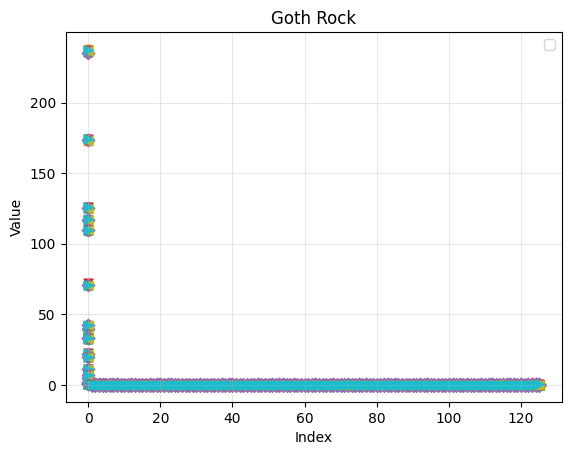

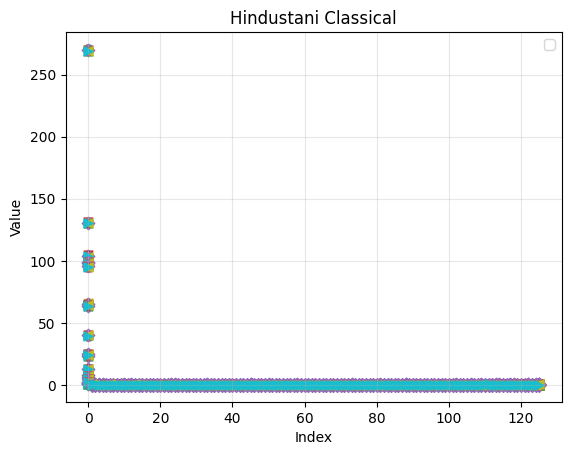

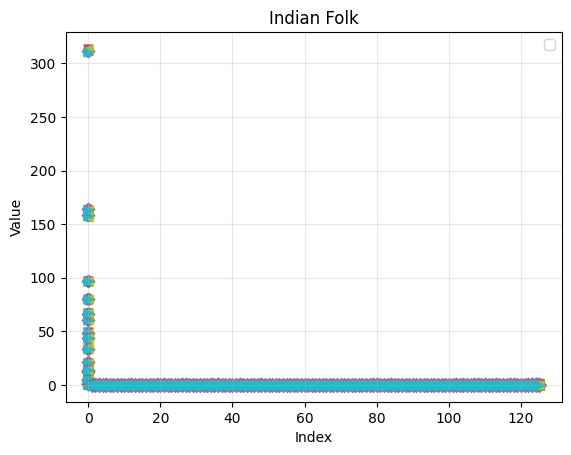

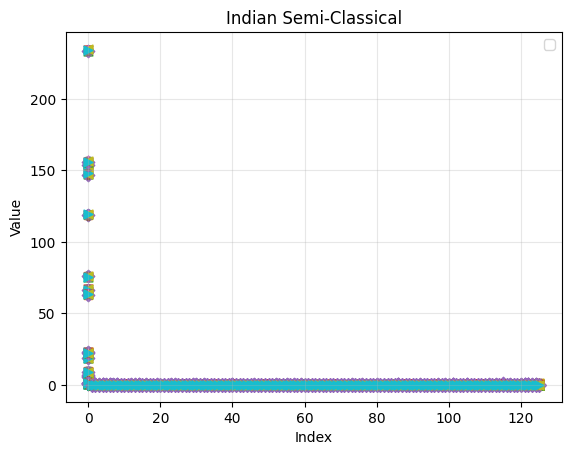

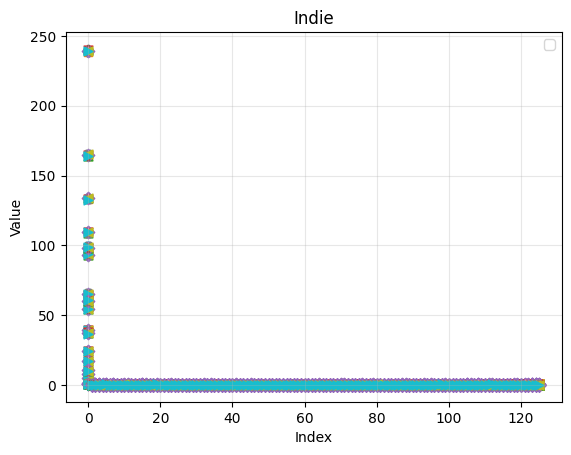

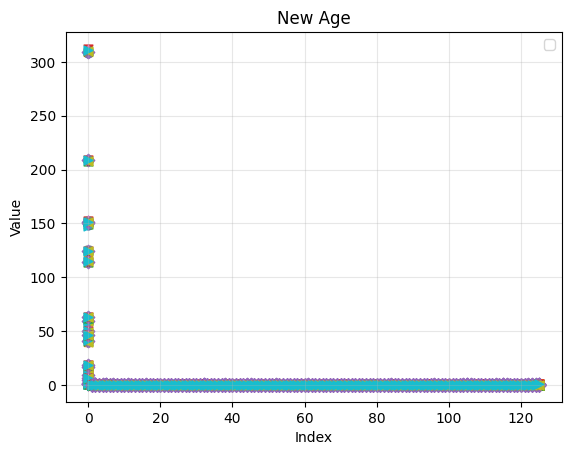

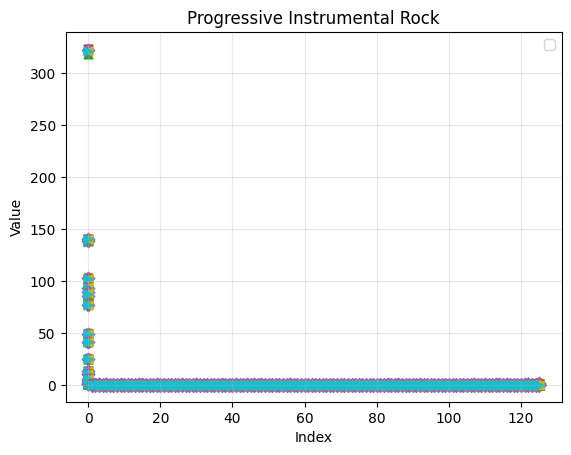

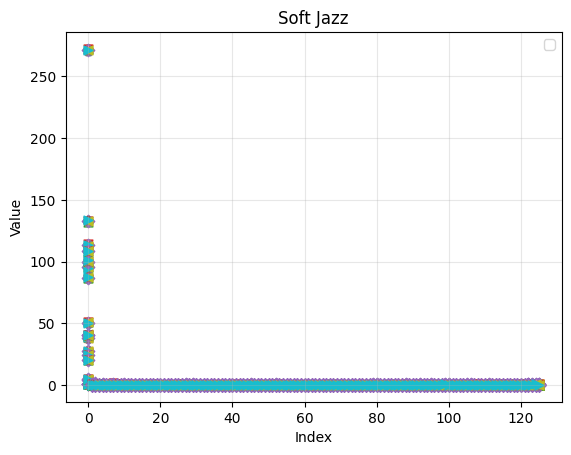

In [70]:
markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', '<', '>']

# Define 10 colors (matplotlib automatically recycles colors if needed)
colors = plt.cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 6))
for t in range(12):
    arr_list = diff_rand[Genres[t]]
    for i, arr in enumerate(arr_list):
        x = np.arange(len(arr))          # x-axis = index of element
        plt.scatter(
            x, arr,
            marker=markers[i % len(markers)],
            color=colors[i % len(colors)],
            s=40
            # label=f"Array {i+1}"
        )

    plt.title(f"{Genres[t]}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.show()

In [49]:
# import matplotlib.pyplot as plt
# x = np.arange(len(differences))

# for i in range(12):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(x[1:], diff[Genres[i]][1:], s=20)   # s = marker size
#     plt.title(f"Eigenvalue Differences- {Genres[i]}")
#     plt.xlabel("Index")
#     plt.ylabel("Difference (value[i] - value[i+1])")
#     plt.grid(True, alpha=0.3)

#     plt.show()

In [12]:
import matplotlib.pyplot as plt

In [ ]:


save_folder = r'EEG_DATA\TE matrix images'
os.makedirs(save_folder, exist_ok=True)

for (key, value), t in zip(aves.items(), range(12)):
    plt.imshow(value , cmap='seismic', interpolation='nearest')
    plt.colorbar(label=' ')
    plt.title(f'{key}')
    #plt.savefig(os.path.join(save_folder, f'{key}_time_{t}.png'))
    #plt.close()
    plt.show()


In [18]:
for key in te_groups.keys():
    # Create main directory for each key
    os.makedirs(f'filtered/{key}', exist_ok=True)

for (key, value), t in zip(te_groups.items(), range(12)):
    for val in range(20):
        filtered = te_groups[key][val] * binary_masks[t]
        np.savetxt(rf'filtered\{key}\{key}_session_{val}.txt', filtered)

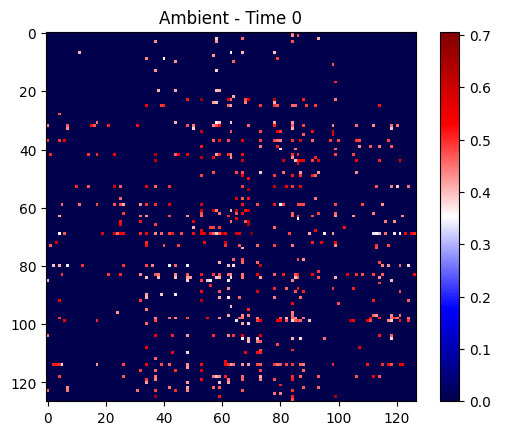

616
Saved: EEG_DATA\forGEPHI\Ambient_time_0.csv


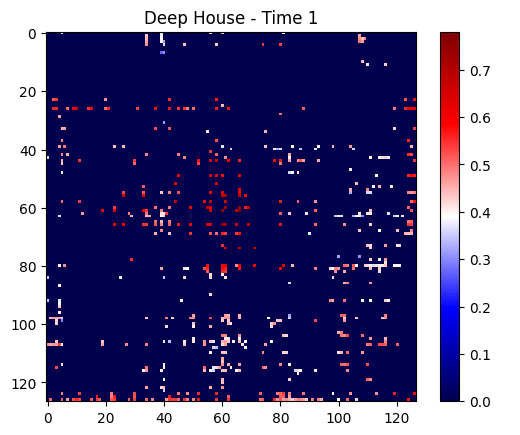

616
Saved: EEG_DATA\forGEPHI\Deep House_time_1.csv


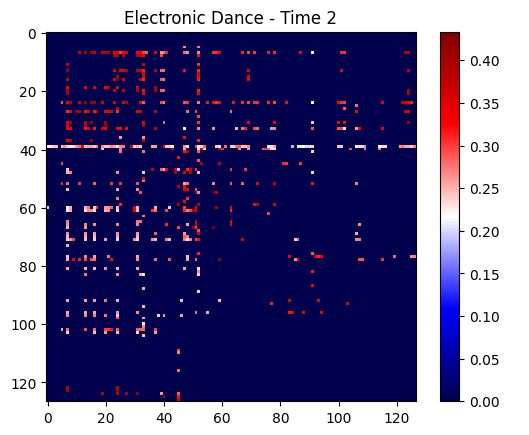

616
Saved: EEG_DATA\forGEPHI\Electronic Dance_time_2.csv


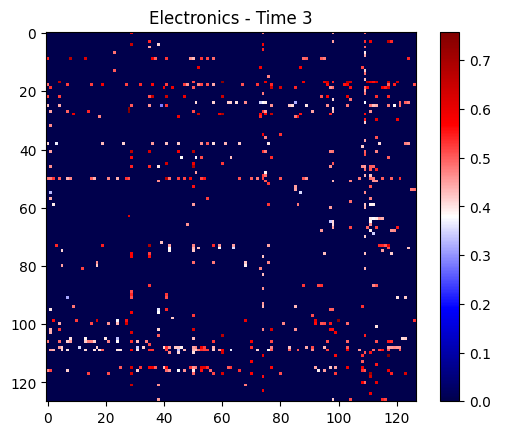

616
Saved: EEG_DATA\forGEPHI\Electronics_time_3.csv


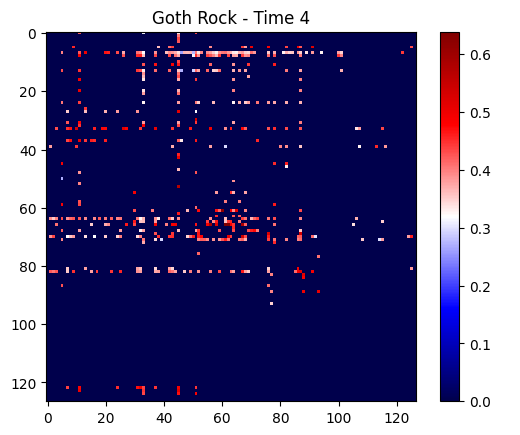

616
Saved: EEG_DATA\forGEPHI\Goth Rock_time_4.csv


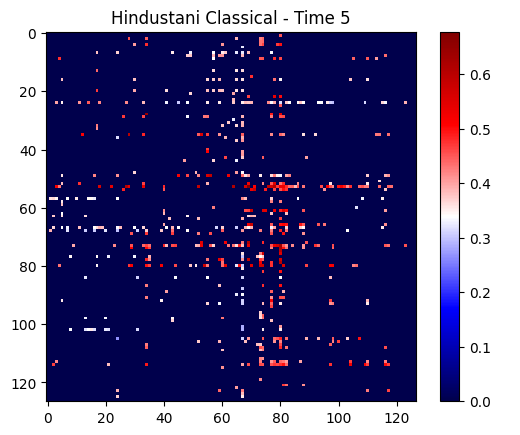

616
Saved: EEG_DATA\forGEPHI\Hindustani Classical_time_5.csv


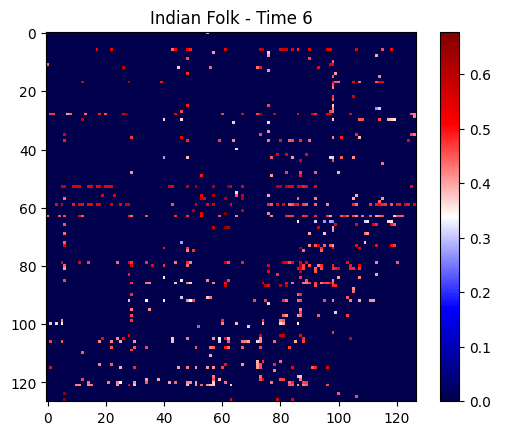

616
Saved: EEG_DATA\forGEPHI\Indian Folk_time_6.csv


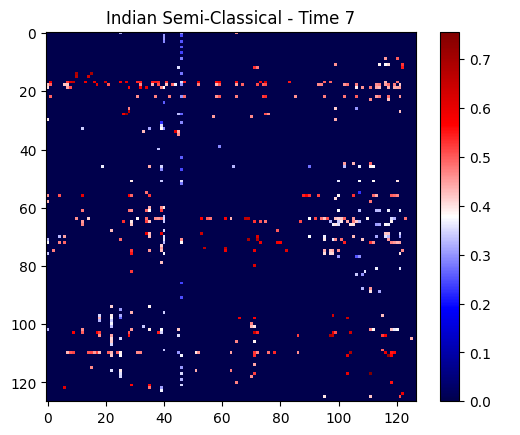

616
Saved: EEG_DATA\forGEPHI\Indian Semi-Classical_time_7.csv


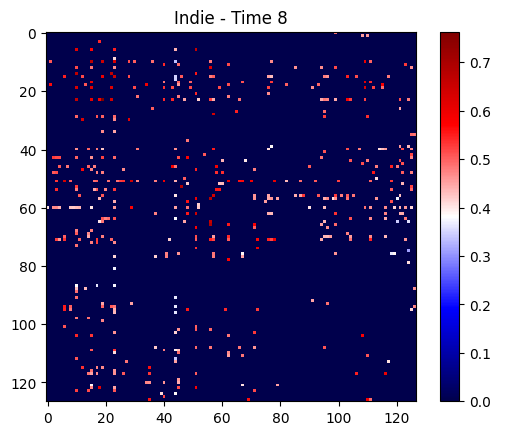

616
Saved: EEG_DATA\forGEPHI\Indie_time_8.csv


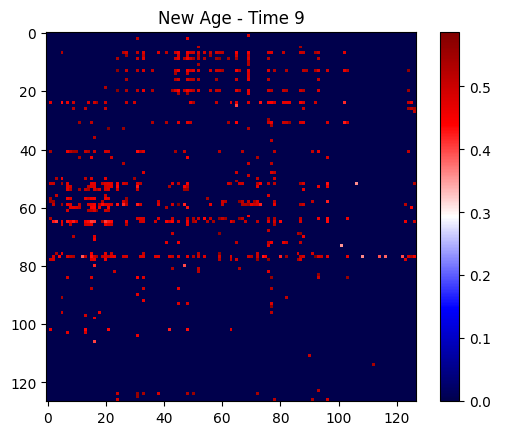

616
Saved: EEG_DATA\forGEPHI\New Age_time_9.csv


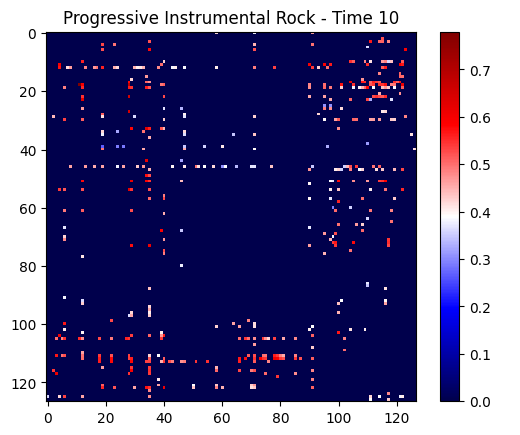

616
Saved: EEG_DATA\forGEPHI\Progressive Instrumental Rock_time_10.csv


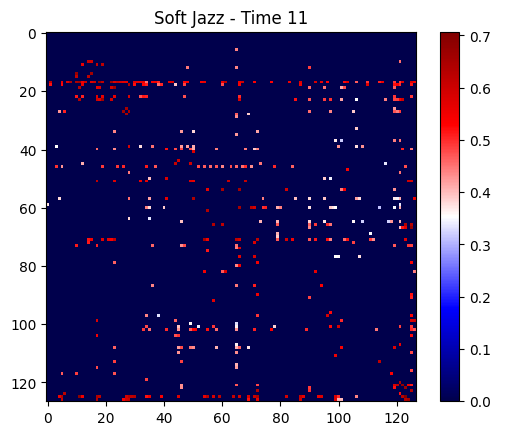

616
Saved: EEG_DATA\forGEPHI\Soft Jazz_time_11.csv


In [13]:
save_folder = r'EEG_DATA\forGEPHI'
for (key, value), t in zip(aves.items(), range(12)):
    plt.imshow(value * binary_masks[t], cmap='seismic', interpolation='nearest')
    plt.colorbar(label=' ')
    plt.title(f'{key} - Time {t}')
    plt.show()
    
    # Create filename from plot title
    filename = f'{key}_time_{t}.csv'
    filepath = os.path.join(save_folder, filename)
    
    # Convert the matrix to an edge list
    print(np.sum(binary_masks[t]))
    matrix = value * binary_masks[t]
    n_nodes = matrix.shape[0]
    
    # Create edge list: Source, Target, Weight
    edges = []
    for i in range(n_nodes):
        for j in range(n_nodes):
            weight = matrix[i, j]
            #if weight != 0:  # Only save non-zero edges (optional)
            edges.append([i, j, weight])
    
    # Save as CSV
    import pandas as pd
    df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])
    df.to_csv(filepath, index=False)
    print(f"Saved: {filepath}")